Simplest version of the transportation model

What's missing?
- power function (for tapering off near 0)
- urban sponge
- cna't seem to get c as a subscript?

In [75]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Roots
using DifferentialEquations

In [76]:
function pred!(dN, N, p, t)
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1
    C²₁₂ = N[5]    # population in corridor 2, lane from patch 1 to patch 2
    C²₂₁ = N[6]    # population in corridor 2, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    β₂ = p[4]       # inverse road capacity, corridor 2
    p1_out = p[5]   # overall demand for leaving P1
    p2_out = p[6]  # overall demand for leaving P2

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)
    F₁ᶜ² = p1_out * exp(-β₂ * α₁ * C²₁₂) * P¹   # flux from patch 1 into corridor 2 (implicitly heading towards patch 2)
    F₂ᶜ² = p2_out * exp(-β₂ * α₂ * C²₂₁) * P²   # flux from patch 2 into corridor 2 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    Fc₂¹ = exp(-β₂ * C²₂₁) * C²₂₁     # flux from corridor 2 into patch 1 (implicitly lane from p2 to p1)
    Fc₂² = exp(-β₂ * C²₁₂) * C²₁₂     # flux from corridor 2 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ + Fc₂¹ - F₁ᶜ¹ - F₁ᶜ² # change in population Patch 1
    dN[2] = Fc₁² + Fc₂² - F₂ᶜ¹ - F₂ᶜ² # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population Corridor 1 lane from p2 to p1
    dN[5] = F₁ᶜ² - Fc₂² # change in population Corridor 2 lane from p1 to p2
    dN[6] = F₂ᶜ² - Fc₂¹ # change in population Corridor 2 lane from p2 to p1
end
# Where to put conservation law??

pred! (generic function with 1 method)

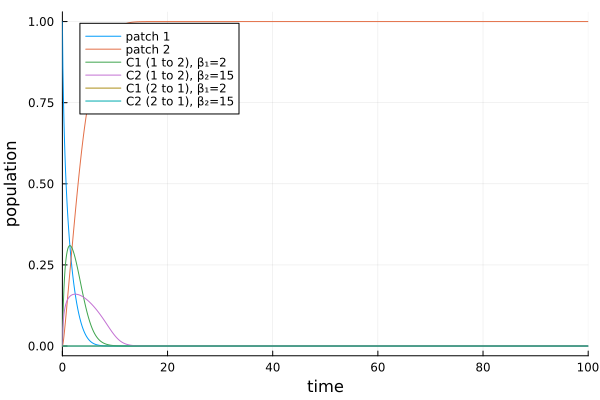

In [195]:
# Choose parameters
α₁ = 1
α₂ = 1
β₁ = 2
β₂ = 15
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, β₂, p1_out, p2_out]

# Solve diff eq
using DifferentialEquations
N0 = [1; 0.; 0; 0; 0; 0]
tspan = (0.0, 100.0)
prob = ODEProblem(pred!, N0, tspan, p)
sol = solve(prob)
using Plots
#plot(sol, idxs = (0, 1, 2))
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C2 (1 to 2), β₂=$β₂")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")
plt = plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C2 (2 to 1), β₂=$β₂")

savefig(plt, "traffic_flows_3.png")

display(plt)

# Plot phase space
#plot(sol, idxs = (1,2), xlabel="P1", ylabel="P2")

Converting to emissions

In [196]:
using Interpolations

# Calculate speeds from densities
v_f = 90 # free-flow velocity, 90 km/hr
k_jam_C1 = 1 / β₁
k_jam_C2 = 1 / β₂

function calc_space_mean_speed(v_f, k, k_jam)
    u_s = v_f - (k/k_jam)*v_f
    return u_s > 0 ? u_s : 0
end

# Make a U-shaped curve
start = 5 # speeds in mph, from California paper
my_step = 5
stop = 100
mph_to_kmh = 1.60934
speed_arr = collect(start:my_step:stop) * mph_to_kmh # convert mph to kmh
emissions_arr = [1200, 950, 700, 500, 425, 350, 325, 310, 309, 308, 308, 308, 309, 320, 330, 350, 375, 400, 450, 550] * mph_to_kmh
plot(speed_arr, emissions_arr)

# Calculate emissions from speeds
interp_fn = linear_interpolation(speed_arr, emissions_arr, extrapolation_bc=Line())

function calc_emissions_from_speed(vehicle_pop_arr, my_speed_arr, interp_fn)
    interpolated_emission_per_vehicle = interp_fn(my_speed_arr)
    emissions = interpolated_emission_per_vehicle .* vehicle_pop_arr
    return emissions
end

# Calculate flow volume
function calc_flow(vehicle_pop_arr, v_f, k_jam)
    q = v_f .* vehicle_pop_arr - (v_f / k_jam) .* vehicle_pop_arr.^2
    return q
end

calc_flow (generic function with 1 method)

### Expected Emissions for travel on C1

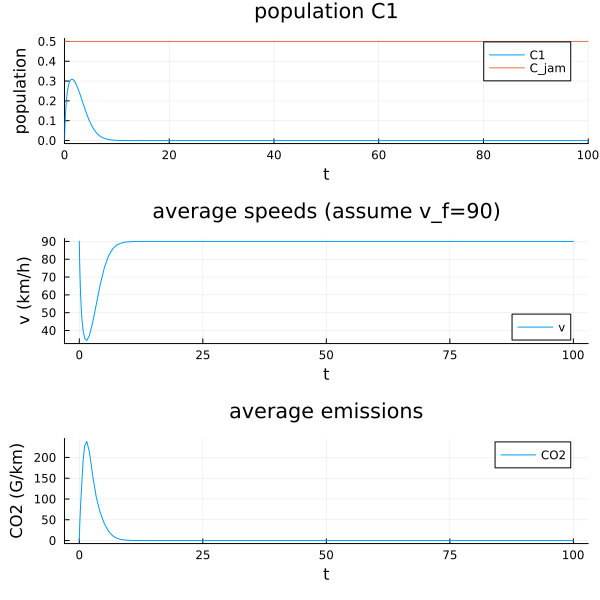

In [197]:
pop_C1 = sol[3, :]
C1_speeds = calc_space_mean_speed.(v_f, pop_C1, k_jam_C1)
C1_emissions = calc_emissions_from_speed(pop_C1, C1_speeds, interp_fn)
C1_flow = calc_flow(pop_C1, v_f, k_jam_C1)

plt1 = plot(sol, idxs=(0,3), xlabel="t", ylabel="population", label="C1")
plt1 = plot!(plt1, [0,100], repeat([k_jam_C1], 2), label="C_jam", title="population C1")
plt2 = plot(sol.t, C1_speeds, xlabel="t", ylabel="v (km/h)", label="v", title="average speeds (assume v_f=90)")
plt3 = plot(sol.t, C1_emissions, xlabel="t", ylabel="CO2 (G/km)", label="CO2", title="average emissions")
plt4 = plot(sol.t, C1_flow, xlabel="t", ylabel="q (vehicles / hour)", label="q", title="traffic flow")

plt = plot(plt1, plt2, plt3, layout = grid(3,1, heights=(1/3,1/3,1/3)), size=(600,600))
#plt = plot(plt1, plt2, plt3, plt4, layout = grid(4,1, heights=(1/4,1/4,1/4,1/4)), size=(600,800))

savefig(plt, "congestion_to_emissions_C1_v3.png")
display(plt)

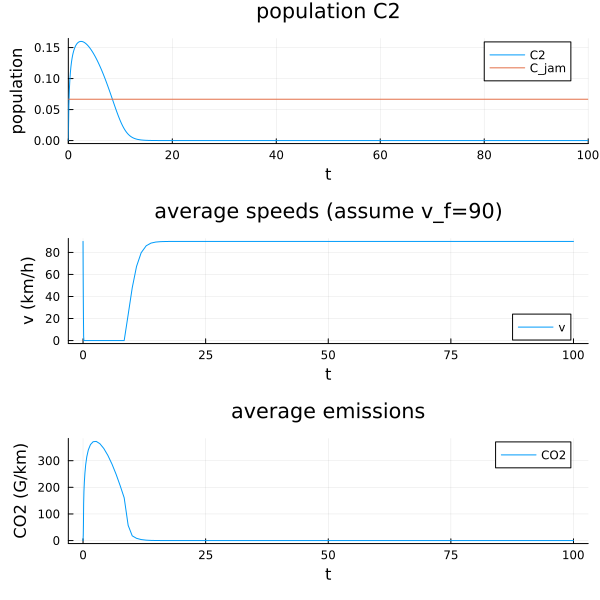

In [198]:
# Same for C2
pop_C2 = sol[5, :]
C2_speeds = calc_space_mean_speed.(v_f, pop_C2, k_jam_C2)
C2_emissions = calc_emissions_from_speed(pop_C2, C2_speeds, interp_fn)
C2_flow = calc_flow(pop_C2, v_f, k_jam_C2)

plt1 = plot(sol, idxs=(0,5), xlabel="t", ylabel="population", label="C2")
plt1 = plot!(plt1, [0,100], repeat([k_jam_C2], 2), label="C_jam", title="population C2")
plt2 = plot(sol.t, C2_speeds, xlabel="t", ylabel="v (km/h)", label="v", title="average speeds (assume v_f=90)")
plt3 = plot(sol.t, C2_emissions, xlabel="t", ylabel="CO2 (G/km)", label="CO2", title="average emissions")
plt4 = plot(sol.t, C2_flow, xlabel="t", ylabel="q (vehicles / hour)", label="q", title="traffic flow")

plt = plot(plt1, plt2, plt3, layout = grid(3,1, heights=(1/3,1/3,1/3)), size=(600,600))
#plt = plot(plt1, plt2, plt3, plt4, layout = grid(4,1, heights=(1/4,1/4,1/4,1/4)), size=(600,800))

savefig(plt, "congestion_to_emissions_C2_v3.png")
display(plt)

## Brainstorming matrix representation
P = [P1, P2, ... Pi]

Connections

number of connections across patches, assume unidirectional, so this matrix doesn't necessarily have to be symmetric about the diagonal
P_conn = 

        [[1, 0, ... 1],

          [0, 2, ... 1],

          ...
          
          [2, 0, ... 1]]

Notice each of these are already directional. Also if there is only one corridor per connected pair of patches, we just need C1. For more, will need multiple matrices Cj.
Ck = 

    [[0, C12, ... C1i],
     
     [C21, 0, ... C2i],
     
     ...
     
     [Ci1, Ci2, ... 0]]

dCk[i,j] = Flow_from_Pi_into_Ck - Flow_from_Ck_into_Pj

Note that not all these patches and corridors are connected, but that's okay -- their flux will just always be zero. Also, this matrix might be three dimensional if there are multiple corridors connecting the same two patches!

i is start, j is final destination, k is corridor (does that make sense if there are jointed corridors?)

F_Pi_through_Ck_heading_to_Pj = [[Flux(P1,P1), Flux(P1,P2), ... 

Flux(P1,Pj)],
                         [Flux(P2,P1), Flux(P2,P2), ... Flux(P2,Pj)],
                         ...
                         [Flux(Pi,P1), Flux(Pi,P2), ... Flux(Pi,Pj)]]

F_Pi_through_Ck_heading_to_Pj[i,j] = exp(-alpha * beta * Ck[i,j]) * P[i]

What is the largest number of connections that we might have for a single node? Probably not more than like 10, right? So it's probably okay to have separate matrices for each Ck.

In [4]:
Flow_from_Pi_into_C1_heading_to_Pj[i,j] = exp(-C1[i,j])*P[i]
Flow_into_Pj_from_C1_starting_at_Pi[i,j] = exp(-C1[i,j])*C1[i,j]
dC1[i,j] = Flow_from_Pi_into_C1_heading_to_Pj[i,j] - Flow_into_Pj_from_C1_starting_at_Pi[i,j]
dP[i] = Flow_into_Pj_from_C1_starting_at_Pi^T

LoadError: UndefVarError: `C1` not defined

In [5]:
P_conn = [0 1; 
          1 0]
P = [0.3; 0.3]
C1 = [0 0.3;
      0.1 0]
Flow_Pi_into_C1_heading_to_Pj = exp(-C1)*P
Flow_Pj_out_of_C1_starting_from_Pi = exp(-C1)*C1
dC1 = Flow_Pi_through_C1_to_Pj
display(P_conn)

LoadError: UndefVarError: `Flow_Pi_through_C1_to_Pj` not defined

In [ ]:
P = [0.3; 0.3]
display(P)

2-element Vector{Float64}:
 0.3
 0.3

In [ ]:
P = [0.3; 0.3]
C1 = [0 0.3;
      0.1 0]
C1*P

2-element Vector{Float64}:
 0.09
 0.03

Attempting matrix representation for simple case

In [6]:
function pred!(dN, N, p, t)
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1
    C²₁₂ = N[5]    # population in corridor 2, lane from patch 1 to patch 2
    C²₂₁ = N[6]    # population in corridor 2, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    β₂ = p[4]       # inverse road capacity, corridor 2
    p1_out = p[5]   # overall demand for leaving P1
    p2_out = p[6]   # overall demand for leaving P2

    for i in 1:n
        for j in 1:n
            Fₚᶜᵏ[i,j] = [p1_out * exp(-β₁ * α₁ * Cᵏ[i,j]) * P[i]] # flux from patch i into corridor k heading in the j direction
            Fᵪₖᵖ = exp(-β₁ * Cᵏ[i,j]) * C[i,j]                    # flux from corridor k (heading from patch i to patch j) into patch j
        end
    end

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)
    F₁ᶜ² = p1_out * exp(-β₂ * α₁ * C²₁₂) * P¹   # flux from patch 1 into corridor 2 (implicitly heading towards patch 2)
    F₂ᶜ² = p2_out * exp(-β₂ * α₂ * C²₂₁) * P²   # flux from patch 2 into corridor 2 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    Fc₂¹ = exp(-β₂ * C²₂₁) * C²₂₁     # flux from corridor 2 into patch 1 (implicitly lane from p2 to p1)
    Fc₂² = exp(-β₂ * C²₁₂) * C²₁₂     # flux from corridor 2 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ + Fc₂¹ - F₁ᶜ¹ - F₁ᶜ² # change in population Patch 1
    dN[2] = Fc₁² + Fc₂² - F₂ᶜ¹ - F₂ᶜ² # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population Corridor 1 lane from p2 to p1
    dN[5] = F₁ᶜ² - Fc₂² # change in population Corridor 2 lane from p1 to p2
    dN[6] = F₂ᶜ² - Fc₂¹ # change in population Corridor 2 lane from p2 to p1
end
# Where to put conservation law??

pred! (generic function with 1 method)

In [7]:
# Choose parameters
α₁ = 1
α₂ = 1
β₁ = 10
β₂ = 60
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, β₂, p1_out, p2_out]

P0 = [0.9, 0.1] # initial population in each patch
C0 = [0 0; 0 0] # assume max 1 corridor for each connection, and no connecting the same og and dest

# Solve diff eq
using DifferentialEquations
N0 = [1; 0.; 0; 0; 0; 0]
tspan = (0.0, 100.0)
prob = ODEProblem(pred!, N0, tspan, p)
sol = solve(prob)
using Plots
#plot(sol, idxs = (0, 1, 2))
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,5), xlabel="time", ylabel="population", label="C2 (1 to 2), β₂=$β₂")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")
plot!(sol, idxs = (0,6), xlabel="time", ylabel="population", label="C2 (2 to 1), β₂=$β₂")

LoadError: UndefVarError: `n` not defined